<a href="https://colab.research.google.com/github/bryaanabraham/medicinal_plant_identifier_app/blob/main/LeafClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
# Importing some useful/necessary packages
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV

from sklearn.metrics import accuracy_score, log_loss

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import cv2

%matplotlib inline

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# Read the .csv files as pandas dataframe
train_raw = pd.read_csv('/content/drive/MyDrive/SIH23/train.csv')
test_raw = pd.read_csv('/content/drive/MyDrive/SIH23/test.csv')

#print type(train_raw), type(test_raw)
print ('There are {}'.format(train_raw.shape[0]),\
       'samples for building the machine learning model and {}'.format(test_raw.shape[0]), \
       'samples for evaluating your model')

There are 990 samples for building the machine learning model and 594 samples for evaluating your model


In [20]:
# Let's look at the first 5 rows of train_raw dataset
train_raw.head(5)

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


In [21]:
# Preprocess the data to fit for the classifier
le = LabelEncoder().fit(train_raw.species) # Instantiate a LabelEncoder and fit to the given label data
labels = le.transform(train_raw.species)  # encode species strings and return labels with value between 0 and n_classes-1
classes = list(le.classes_)  # Save the species
test_ids = test_raw.id  # Save the image ids in test dataset

train = train_raw.drop(['id', 'species'], axis=1)
test = test_raw.drop(['id'], axis=1)

In [22]:
# Double check the data
print ("The shapes of train and labels are: ", train.shape, labels.shape)
print ("There are {} species in total.".format(len(classes)) )
print("The shapes of test and test_ids are: ", test.shape, test_ids.shape)

The shapes of train and labels are:  (990, 192) (990,)
There are 99 species in total.
The shapes of test and test_ids are:  (594, 192) (594,)


In [23]:
# construct the iterator
ss_split = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
ss_split.get_n_splits(train, labels)

for train_index, test_index in ss_split.split(train, labels):
    X_train, X_test = train.values[train_index], train.values[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

In [24]:
# Double check the data
print (y_train.shape, y_test.shape)

(792,) (198,)


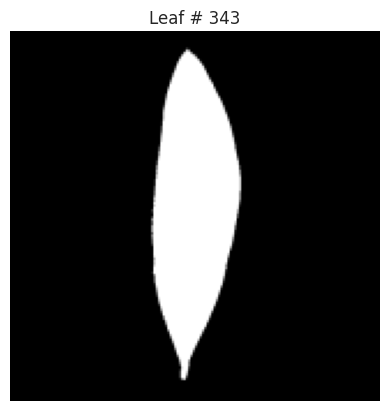

In [25]:
def leaf_image(image_id,target_length=160):
    """
    `image_id` should be the index of the image in the images/ folder

    Reture the image of a given id(1~1584) with the target size (target_length x target_length)

    """

    image_name = str(image_id) + '.jpg'
    leaf_img = plt.imread('/content/drive/MyDrive/SIH23/images/'+image_name)  # Reading in the image
    leaf_img_width = leaf_img.shape[1]
    leaf_img_height = leaf_img.shape[0]
    #target_length = 160
    img_target = np.zeros((target_length, target_length), np.uint8)
    if leaf_img_width >= leaf_img_height:
        scale_img_width = target_length
        scale_img_height = int( (float(scale_img_width)/leaf_img_width)*leaf_img_height )
        img_scaled = cv2.resize(leaf_img, (scale_img_width, scale_img_height), interpolation = cv2.INTER_AREA)
        copy_location = int((target_length-scale_img_height)/2)
        img_target[copy_location:copy_location+scale_img_height,:] = img_scaled
    else:
        # leaf_img_width < leaf_img_height:
        scale_img_height = target_length
        scale_img_width = int( (float(scale_img_height)/leaf_img_height)*leaf_img_width )
        img_scaled = cv2.resize(leaf_img, (scale_img_width, scale_img_height), interpolation = cv2.INTER_AREA)
        copy_location = int((target_length-scale_img_width)/2)
        img_target[:, copy_location:copy_location+scale_img_width] = img_scaled

    return img_target


# Test the leaf_image function
leaf_id = 343
leaf_img = leaf_image(leaf_id, target_length=160);

plt.imshow(leaf_img, cmap='gray'); plt.title('Leaf # '+str(leaf_id)); plt.axis('off'); plt.show()

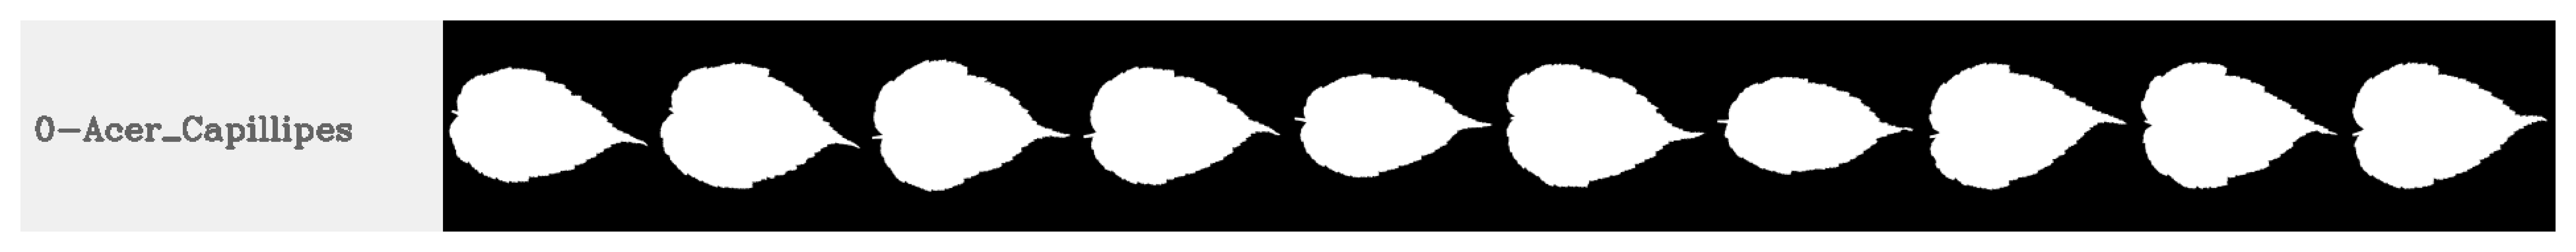

0-Acer_Capillipes


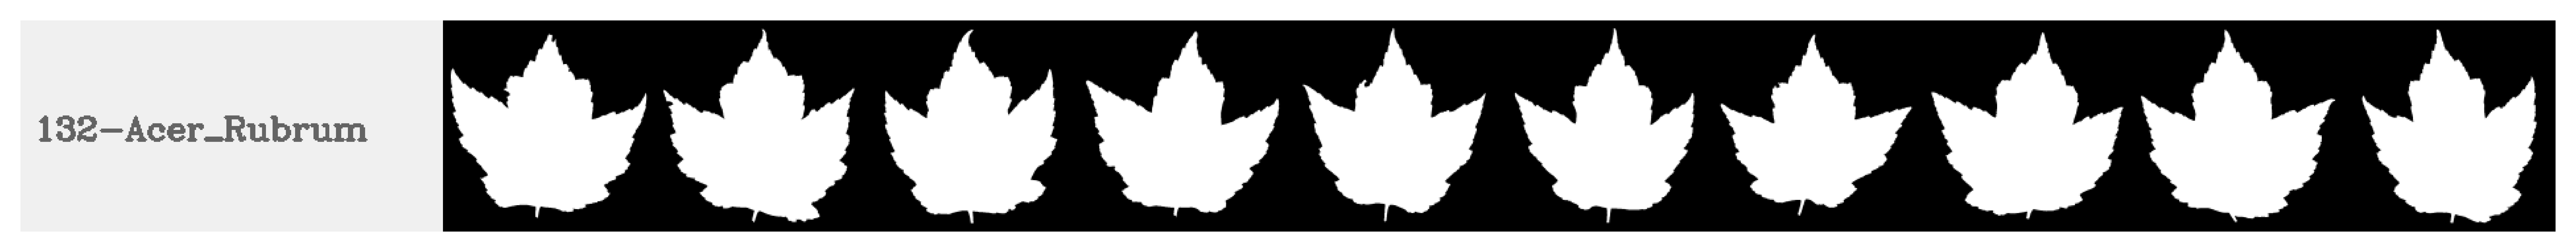

In [34]:
def species_image(species):
    """
    `species` should be the index or species name

    Returns an image of a certain labeled species
    """

    leaf_image_length = 160
    #img_target = np.zeros([leaf_image_length, 0], np.uint8)  # Initialization
    img_target = 240*np.ones([leaf_image_length, leaf_image_length*2], np.uint8)  # Initialization
    label_info = ''
    #if type(species)==int and species >= 0 and species < 99:
    if type(species)==int and species >= 0 and species < 99:
        images_index = np.where(labels==species)[0]
        label_info = str(species) + '-' + train_raw.species[images_index[0]]
    elif type(species)==str and species in classes:
        images_index = np.where(train_raw.species==species)[0]
        label_info = str(images_index[0]) + '-' + species
    else:
        print ('Error: Please input a valid index or species name')
        return
    for image_index in images_index:
        image_id = train_raw.id[image_index]
        leaf_img = leaf_image(image_id)
        img_target = np.append(img_target, leaf_img, axis=1)

    # Add information onto the first block
    cv2.putText(img_target, label_info, (10,90), cv2.FONT_HERSHEY_COMPLEX, 0.8, (100,170,0), 2)

    return img_target, label_info



# Test the function
species_img, label_info = species_image(0)  # Show this species of given index(0~98)
fig = plt.figure(num=None, figsize=(16, 3), dpi=1200, facecolor='w', edgecolor='w',frameon=False,linewidth = 0)
plt.imshow(species_img, cmap='gray'); plt.axis('off'); plt.show()
print (label_info)
#cv2.imwrite('species/'+label_info+'.jpg', species_img)  # Save the species image


species_img, label_info = species_image('Acer_Rubrum')  # show the species of give name
fig = plt.figure(num=None, figsize=(16, 3), dpi=1200, facecolor='w', edgecolor='w',frameon=False,linewidth = 0)
plt.imshow(species_img, cmap='gray'); plt.axis('off'); plt.show()

In [36]:
def visualize_error(train_predictions, y_test):
    """
    Review the images where mistakes occur
    """
    error_indices = np.where(train_predictions != y_test)[0]
    print('The error indices: ', error_indices)

    for err_index in error_indices:
        print('Error index in the test set: ', err_index)

        err_img_index = train_raw.id[test_index[err_index]]

        print('Ground truth species index: {}'.format(y_test[err_index]))
        print('Wrong predicting species index: {}'.format(train_predictions[err_index]))

        plt.imshow(leaf_image(err_img_index, 160), cmap='gray')
        plt.axis('off')
        plt.show()

        # Check if species_image() returns a valid result before unpacking
        result = species_image(train_predictions[err_index])
        if result is not None:
            wrong_pred_species_img, label_info = result

            fig = plt.figure(num=None, figsize=(16, 3), dpi=1200, facecolor='w', edgecolor='w', frameon=False, linewidth=0)
            wrong_pred_species_img = cv2.cvtColor(wrong_pred_species_img, cv2.COLOR_GRAY2RGB)
            wrong_pred_species_img = cv2.copyMakeBorder(wrong_pred_species_img, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[255, 0, 0])

            plt.imshow(wrong_pred_species_img, cmap='gray')
            plt.axis('off')
            plt.show()

        # Similarly, check if species_image() returns a valid result for ground truth
        result = species_image(y_test[err_index])
        if result is not None:
            ground_truth_species_img, label_info = result

            fig = plt.figure(num=None, figsize=(16, 3), dpi=1200, facecolor='w', edgecolor='w', frameon=False, linewidth=0)
            plt.imshow(ground_truth_species_img, cmap='gray')
            plt.axis('off')
            plt.show()

        print('#' * 50)

In [28]:
# List and save all the classes
for i, class_ in enumerate(classes):
    species_img, label_info = species_image(i)  # Show this species of given index(0~98)
    print (label_info)
    cv2.imwrite('species/'+label_info+'.jpg', species_img)

0-Acer_Capillipes
1-Acer_Circinatum
2-Acer_Mono
3-Acer_Opalus
4-Acer_Palmatum
5-Acer_Pictum
6-Acer_Platanoids
7-Acer_Rubrum
8-Acer_Rufinerve
9-Acer_Saccharinum
10-Alnus_Cordata
11-Alnus_Maximowiczii
12-Alnus_Rubra
13-Alnus_Sieboldiana
14-Alnus_Viridis
15-Arundinaria_Simonii
16-Betula_Austrosinensis
17-Betula_Pendula
18-Callicarpa_Bodinieri
19-Castanea_Sativa
20-Celtis_Koraiensis
21-Cercis_Siliquastrum
22-Cornus_Chinensis
23-Cornus_Controversa
24-Cornus_Macrophylla
25-Cotinus_Coggygria
26-Crataegus_Monogyna
27-Cytisus_Battandieri
28-Eucalyptus_Glaucescens
29-Eucalyptus_Neglecta
30-Eucalyptus_Urnigera
31-Fagus_Sylvatica
32-Ginkgo_Biloba
33-Ilex_Aquifolium
34-Ilex_Cornuta
35-Liquidambar_Styraciflua
36-Liriodendron_Tulipifera
37-Lithocarpus_Cleistocarpus
38-Lithocarpus_Edulis
39-Magnolia_Heptapeta
40-Magnolia_Salicifolia
41-Morus_Nigra
42-Olea_Europaea
43-Phildelphus
44-Populus_Adenopoda
45-Populus_Grandidentata
46-Populus_Nigra
47-Prunus_Avium
48-Prunus_X_Shmittii
49-Pterocarya_Stenoptera

In [29]:
# Standardize the training data.
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

#param_grid = {'C':[1, 10],
#              'tol': [0.001, 0.0001]}
param_grid = {'C': [ 1000, 10000],
              'tol': [0.000001, 0.00001]}
log_reg = LogisticRegression(solver='newton-cg', multi_class='multinomial')
grid_search = GridSearchCV(log_reg, param_grid, scoring='neg_log_loss', refit='True', n_jobs=1, cv=ss_split)
grid_search.fit(X_train_scaled, y_train)

print ('Best parameter: {}'.format(grid_search.best_params_))
print ('Best cross-validation neg_log_loss score: {}'.format(grid_search.best_score_))
print ('\nBest estimator:\n{}'.format(grid_search.best_estimator_))

Best parameter: {'C': 1000, 'tol': 1e-06}
Best cross-validation neg_log_loss score: -0.0596472166397339

Best estimator:
LogisticRegression(C=1000, multi_class='multinomial', solver='newton-cg',
                   tol=1e-06)


In [30]:
scaler = StandardScaler().fit(X_test)
X_test_scaled = scaler.transform(X_test)

print ('ML Model: Logistic Regression')
# Accuracy
train_predictions = grid_search.predict(X_test_scaled)
acc = accuracy_score(y_test, train_predictions)
print ('Accuracy: {:.4%}'.format(acc))
# Logloss
train_predictions_p = grid_search.predict_proba(X_test_scaled)
ll = log_loss(y_test, train_predictions_p)
print ('Log Loss: {:.6}'.format(ll))

ML Model: Logistic Regression
Accuracy: 98.9899%
Log Loss: 0.0253898


The error indices:  [ 24 125]
Error index in the test set:  24
Ground truth species index: 48
Wrong predicting species index: 41


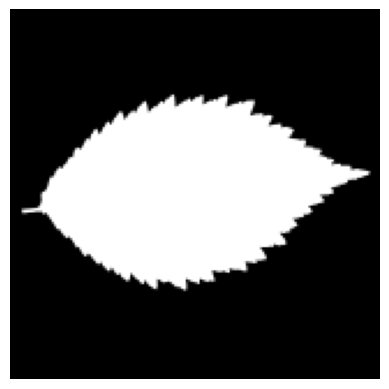

Error: Please input a valid index or species name
Error: Please input a valid index or species name
##################################################
Error index in the test set:  125
Ground truth species index: 29
Wrong predicting species index: 28


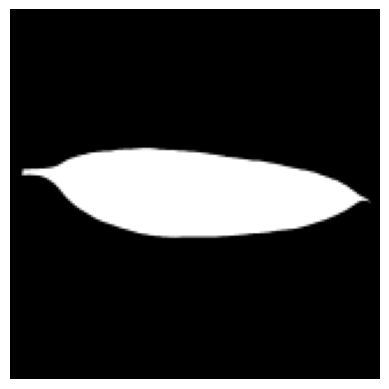

Error: Please input a valid index or species name
Error: Please input a valid index or species name
##################################################


In [37]:
visualize_error(train_predictions, y_test)

In [45]:
# Standardize the training data.
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

# Using the optimal parameters
param_grid = {'C': [1000],
              'tol': [0.000001]}
log_reg = LogisticRegression(solver='newton-cg', multi_class='multinomial')
grid_search = GridSearchCV(log_reg, param_grid, scoring='neg_log_loss', refit='True', n_jobs=1, cv=ss_split)
grid_search.fit(X_train_scaled, y_train)


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=0, test_size=0.2,
            train_size=None),
             estimator=LogisticRegression(multi_class='multinomial',
                                          solver='newton-cg'),
             n_jobs=1, param_grid={'C': [1000], 'tol': [1e-06]}, refit='True',
             scoring='neg_log_loss')

In [47]:
scaler = StandardScaler().fit(test)
test_scaled = scaler.transform(test)

test_predictions = grid_search.predict_proba(test_scaled)

# Format DataFrame
submission = pd.DataFrame(test_predictions, columns=classes)
submission.insert(0, 'id', test_ids)
submission.reset_index()

# Export Submission
submission.to_csv('submission_1208.csv', index = False)

# Double check the output
submission.head()

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,4,9.007515e-11,1.110549e-09,2.631914e-13,3.720929e-08,2.350729e-09,4.063996e-09,1.768673e-13,2.364584e-12,7.385758e-12,...,5.027327e-15,8.301695e-10,2.903943e-10,1.290759e-11,2.987716e-09,7.929223e-13,1.093496e-13,3.405795e-15,3.417034e-07,7.518883e-12
1,7,7.568429e-10,6.802680e-09,7.777165e-08,5.441981e-07,1.543852e-09,9.540572e-09,7.876626e-06,1.120785e-09,1.172143e-09,...,1.600127e-08,2.606566e-08,4.107676e-11,2.318086e-12,1.294310e-14,1.906001e-06,2.574194e-09,3.042102e-06,2.757133e-10,1.193133e-08
2,9,5.304156e-08,9.973276e-01,1.104277e-07,3.862212e-08,2.147774e-03,3.742826e-06,2.818388e-08,8.376719e-06,5.784712e-05,...,2.252547e-07,6.741919e-09,6.966371e-08,1.280252e-08,3.415543e-09,6.894387e-09,1.382053e-07,5.417998e-11,1.218199e-08,6.960277e-05
3,12,2.785309e-09,1.212889e-03,8.258612e-08,1.851719e-08,2.190390e-07,3.165733e-09,8.427779e-06,2.894866e-07,6.234967e-06,...,5.253309e-07,7.977082e-09,7.652494e-08,5.446850e-10,2.526392e-10,7.760739e-07,5.167058e-04,2.915690e-08,4.290963e-09,7.707777e-05
4,13,5.941531e-08,5.114018e-08,1.420712e-10,1.702825e-11,2.943797e-08,1.402327e-10,5.364150e-08,7.859934e-09,3.747318e-06,...,2.472362e-08,9.548113e-11,4.751378e-07,3.630461e-10,5.300772e-07,2.563174e-07,3.842250e-06,9.350164e-10,1.240185e-08,9.273208e-09


In [64]:
# Assuming submission is a DataFrame
max_value = submission.max()  # Find the maximum value along each column

# Drop the 'id' column from the Series, compute the maximum value, and get its index (which is the 'id')
max_id = max_value.drop('id', axis=0).idxmax()

# Print the maximum value and its associated 'id'
print(f"Maximum Value: {max_value[max_id]} (ID: {max_id})")


Maximum Value: 0.9999999943497837 (ID: Acer_Saccharinum)
